# Feature Engineering, Singular Value Decomposition, and Principal Components Analysis in R

**April 2018**

### **Author:** Lauren Washington

The most significant part of the Data Scientist role is data cleaning, manipulation, and engineering. Once you do the necessary cleaning of your data (imputing/removing missing values, removing duplicates, changing data types)-- it's good to do feature engineering. There are multiple ways to approach this Data Science task. Some things we will focus on in this post are how to create new features from existing features, change categorical data into binary/dummy variables, transform non-normal data into normal, and transform non-linear into linear. We will also go into an unsupervised feature selection technique known as Principal Components Analysis.

## Cleaning the Data

The data for this post is from Kaggle.com. The goal of the competition is to predict the SalePrice for a property.

**Housing Data:** https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [3]:
#load required libraries
lapply(c("ggplot2", "reshape2", "dplyr", "dummies", 
         "car", "scales", "rpart", "lattice"), require, character.only = TRUE)

Loading required package: ggplot2
Loading required package: reshape2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: dummies
dummies-1.5.6 provided by Decision Patterns

Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

Loading required package: scales
Loading required package: rpart
Loading required package: lattice


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

In [4]:
#use multiplot function for data viz subplots 
#http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

We will start by importing both the test and train data. After performing necessary cleaning, we will proceed to engineer new features and then reduce the dimensionality of our feature set. Feature engineering involves creativity, and the elements you create during your first run may not be enough to get the desired accuracy. An undesirable accuracy score is acceptable on a first run -- as data science is an iterative process. In this post I will take you through how to recode and operationalize your features, changing variable types, interact terms, transform to normally distributed data, create linear transformations, interacting terms, utilizing Singular Value Decomposition, and Principal Components Analysis. We will conclude this post with a comparison of accuracy results for the different sets of training data.

In [5]:
#import data
housing <- read.csv("train.csv")
test <- read.csv("test.csv")

In [6]:
#compare number of features and makes sure test has one less (minus the target)
cat("The training data has", ncol(housing), "features. The testing set has", ncol(test), "features.")

The training data has 81 features. The testing set has 80 features.

In [7]:
#view first 6 lines of training data
head(housing)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [8]:
head(test)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,⋯,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,⋯,144,0,NA,NA,NA,0,1,2010,WD,Normal
1466,60,RL,75,10000,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,NA,0,4,2010,WD,Normal


In [9]:
#combine test and control for cleaning
combined_train_test <- housing 
combined_train_test$SalePrice <- NULL
combined_train_test <- rbind(combined_train_test, test)

In [10]:
#check for duplicate values
sum(duplicated(housing) == TRUE)

[1] 0

In [11]:
#check data for missing values

#NAs in LotFrontage(259), Alley(1369), MasVnrType(8), MasVanArea(8), BsmtQual(37), BsmtCond(37), BsmtExposure(38),
#BsmtFinType1(37), BsmtFinType2(38), Electrical(1), GarageType(81), GarageYrBlt(81), 
#GarageFinish(81), GarageQual(81), GarageCond(81), Fence(1179), MiscFeature(1406)
summary(housing)

       Id           MSSubClass       MSZoning     LotFrontage    
 Min.   :   1.0   Min.   : 20.0   C (all):  10   Min.   : 21.00  
 1st Qu.: 365.8   1st Qu.: 20.0   FV     :  65   1st Qu.: 59.00  
 Median : 730.5   Median : 50.0   RH     :  16   Median : 69.00  
 Mean   : 730.5   Mean   : 56.9   RL     :1151   Mean   : 70.05  
 3rd Qu.:1095.2   3rd Qu.: 70.0   RM     : 218   3rd Qu.: 80.00  
 Max.   :1460.0   Max.   :190.0                  Max.   :313.00  
                                                 NA's   :259     
    LotArea        Street      Alley      LotShape  LandContour  Utilities   
 Min.   :  1300   Grvl:   6   Grvl:  50   IR1:484   Bnk:  63    AllPub:1459  
 1st Qu.:  7554   Pave:1454   Pave:  41   IR2: 41   HLS:  50    NoSeWa:   1  
 Median :  9478               NA's:1369   IR3: 10   Low:  36                 
 Mean   : 10517                           Reg:925   Lvl:1311                 
 3rd Qu.: 11602                                                              
 Max

In [12]:
#drop Alley, Fence, and Misc Features for having too many missing values
housing$Alley <- NULL
housing$Fence <- NULL
housing$MiscFeature <- NULL

In [13]:
#create numeric subset of data for basic correlations
numeric_df <- housing[sapply(housing, is.numeric)]

In [14]:
cor_matrix <- cor(numeric_df, use = "pairwise.complete.obs")
cor_matrix

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000e+00,0.011156478,-0.010600689,-0.033225519,-0.02836475,0.012608925,-0.012712715,-0.021997642,-0.050297795,-0.005024049,⋯,-0.029643197,-0.0004769113,0.002889218,-0.0466347889,0.001330209,0.057043905,-0.0062424048,0.021172177,0.000711794,-0.02191672
MSSubClass,1.115648e-02,1.000000000,-0.386346885,-0.139781082,0.03262771,-0.059315817,0.027850137,0.040581045,0.022936286,-0.069835749,⋯,-0.012579358,-0.0061001212,-0.012036622,-0.0438245492,-0.026030177,0.008282708,-0.0076832913,-0.013584643,-0.021407038,-0.08428414
LotFrontage,-1.060069e-02,-0.386346885,1.000000000,0.426095019,0.25164578,-0.059213450,0.123349467,0.088865572,0.193458061,0.233633167,⋯,0.088520933,0.1519722277,0.010700337,0.0700292277,0.041382791,0.206166775,0.0033675566,0.011199955,0.007449589,0.35179910
LotArea,-3.322552e-02,-0.139781082,0.426095019,1.000000000,0.10580574,-0.005636270,0.014227652,0.013788427,0.104159822,0.214103131,⋯,0.171697687,0.0847738088,-0.018339734,0.0204228296,0.043160378,0.077672392,0.0380676920,0.001204988,-0.014261407,0.26384335
OverallQual,-2.836475e-02,0.032627708,0.251645775,0.105805742,1.00000000,-0.091932343,0.572322769,0.550683924,0.411875667,0.239665966,⋯,0.238923392,0.3088188234,-0.113936859,0.0303705671,0.064886360,0.065165844,-0.0314062105,0.070815172,-0.027346708,0.79098160
OverallCond,1.260892e-02,-0.059315817,-0.059213450,-0.005636270,-0.09193234,1.000000000,-0.375983196,0.073741498,-0.128101199,-0.046230856,⋯,-0.003333699,-0.0325888135,0.070356184,0.0255036600,0.054810529,-0.001984942,0.0687768061,-0.003510839,0.043949746,-0.07785589
YearBuilt,-1.271272e-02,0.027850137,0.123349467,0.014227652,0.57232277,-0.375983196,1.000000000,0.592854976,0.315707062,0.249503197,⋯,0.224880142,0.1886858400,-0.387267783,0.0313545131,-0.050364435,0.004949728,-0.0343831387,0.012398471,-0.013617680,0.52289733
YearRemodAdd,-2.199764e-02,0.040581045,0.088865572,0.013788427,0.55068392,0.073741498,0.592854976,1.000000000,0.179618371,0.128450547,⋯,0.205725920,0.2262976327,-0.193919147,0.0452858098,-0.038740011,0.005829372,-0.0102862488,0.021490002,0.035743247,0.50710097
MasVnrArea,-5.029780e-02,0.022936286,0.193458061,0.104159822,0.41187567,-0.128101199,0.315707062,0.179618371,1.000000000,0.264736265,⋯,0.159718134,0.1257027967,-0.110203834,0.0187955153,0.061465543,0.011723061,-0.0298153936,-0.005964716,-0.008201031,0.47749305
BsmtFinSF1,-5.024049e-03,-0.069835749,0.233633167,0.214103131,0.23966597,-0.046230856,0.249503197,0.128450547,0.264736265,1.000000000,⋯,0.204306145,0.1117606134,-0.102303306,0.0264505062,0.062020623,0.140491286,0.0035714735,-0.015726948,0.014358922,0.38641981


In [15]:
#reassign the lower diagonal of the correlation matrix to NA
cor_matrix[lower.tri(cor_matrix, diag = TRUE)] <- NA  
#melt and subset correlation matrix
cor_matrix <- subset(melt(cor_matrix, na.rm = TRUE), value > .50)   
#look at the most highly correlated features
cor_matrix

,Var1,Var2,value
233,OverallQual,YearBuilt,0.5723228
271,OverallQual,YearRemodAdd,0.5506839
273,YearBuilt,YearRemodAdd,0.5928550
461,OverallQual,TotalBsmtSF,0.5378085
466,BsmtFinSF1,TotalBsmtSF,0.5223961
507,TotalBsmtSF,X1stFlrSF,0.8195300
613,OverallQual,GrLivArea,0.5930074
622,X1stFlrSF,GrLivArea,0.5660240
623,X2ndFlrSF,GrLivArea,0.6875011
656,BsmtFinSF1,BsmtFullBath,0.6492118


In [16]:
#look at the fetures most highly correlated with the dependent variable SalePrice
subset(cor_matrix, cor_matrix[2] == 'SalePrice')

,Var1,Var2,value
1411,OverallQual,SalePrice,0.7909816
1413,YearBuilt,SalePrice,0.5228973
1414,YearRemodAdd,SalePrice,0.5071010
1419,TotalBsmtSF,SalePrice,0.6135806
1420,X1stFlrSF,SalePrice,0.6058522
1423,GrLivArea,SalePrice,0.7086245
1426,FullBath,SalePrice,0.5606638
1430,TotRmsAbvGrd,SalePrice,0.5337232
1433,GarageCars,SalePrice,0.6404092
1434,GarageArea,SalePrice,0.6234314


# Feature Engineering

## Recoding Variables to Align with Research Problem

To start, I would like to highlight the act of recoding variables to align with your particular research problem. We won't be doing this particular step in this analysis, but it is still worth highlighting. 

Features may be represented in different units than the research question. For example, maybe you have data in centimeters, but the problem uses feet. It could be useful to transform the feature into something easily transferable to the desired solution. 

You may also have features with ambiguous names which you are using to measure things such as level of exercise, quality of sleep, level of anxiety, etc. To make it easier to interpret the results from the analysis, it is sometimes helpful to recode things on an ordinal scale to imply an increase in a particular category. 

## Changing Variable Types

Sometimes you may want to transform a continuous variable into categorical. For instance, maybe you want a feature indicating if a property has >= the median square footage of all properties in the population. 

In [17]:
housing$sqft_greater_median = ifelse(housing$X1stFlrSF >= 1087, 1, 0)

In [18]:
cat(percent(round(sum(housing$sqft_greater_median == 1) / nrow(housing), 3)), 
    "percent of properties have a 1st floor sqft >= to the median value of", median(combined_train_test$X1stFlrSF),".")


50% percent of properties have a 1st floor sqft >= to the median value of 1082 .

## Correlated Variables

There are also ways to prevent including redundant information in your model. If during the Exploratory Data Analysis phase you discover that pairs of variables are highly correlated and tell similar information then you can choose to create a new feature by combining the two or simply drop one of the features. One way of combining the features is to take the average of the two features. If there are three or more features then you can also try methods of dimensionality reduction like Singular Value Decomposition or Principal Components Analysis.

YearBuilt and YearRemodelAdd (0.5928550) Added are highly correlated , as well as TotalBsmtSF and X1stFlrSF (0.8195300), FullBath and TotRmsAbvGrd (0.5547843), and GarageCars and GarageArea (0.8824754). Instead of having highly correlated variables we could combine the features by taking the average.

In [19]:
housing$year_built_remodel_avg <- (housing$YearBuilt + housing$YearRemodAdd) / 2
housing$tot_bsmt_sf_x1st_flr_sf_avg <- (housing$TotalBsmtSF + housing$X1stFlrSF) / 2
housing$full_bath_tot_rms_abv_grd_avg <- (housing$FullBath + housing$TotRmsAbvGrd) / 2
housing$garage_cars_garage_area_avg <- (housing$GarageCars + housing$GarageArea) / 2

## Categorical Variables

Sometimes you may want to make additional features from the current categorical variables. You can do this by creating new categories such as partOfTown (based on the neighborhood column). The part of town feature could indicate if a neighborhood is in the north, south, east, west, etc. side of town.

Or we could do a binary variable indicating if a house was remodeled within the last decade.  

We could also create dummy variables for our categorical variables. Creating dummy variables of a category creates n- 1 new binary features. One factor level is removed and considered the reference group as the inference is possible based on the results of the other factor levels. For example, if Neighborhood is turned into a dummy variable and all of the factor levels = 0 then we can conclude that the reference level is equal to 1. Also, if one is already present, then we can infer the reference is equal to 0. Another bonus to creating dummy variables is the conversion from factor to numeric. As you can see, we are only able to produce correlation results on quantitative data. The requirement of numeric data is true for a great amount of Machine Learning algorithms, as well. Creating dummy variables will make your life easier, as a data scientist, and will provide deeper insights into the micro level correlations found within a category. 

In [20]:
housing_w_dummy_vars <- cbind(housing, dummy(housing$full_bath_tot_rms_abv_grd_avg, sep = "_"))

In [21]:
# create 2 new training data I. all four features II.just > .80 correlation

cor_dum <- cor(housing_w_dummy_vars[sapply(housing_w_dummy_vars, is.numeric)], use = "pairwise.complete.obs")
cor_dum

Warning message in cor(housing_w_dummy_vars[sapply(housing_w_dummy_vars, is.numeric)], :
“the standard deviation is zero”

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,NA_3.5,NA_4,NA_4.5,NA_5,NA_5.5,NA_6,NA_6.5,NA_7,NA_7.5,NA_8
Id,1.000000e+00,0.0111564782,-0.010600689,-0.0332255186,-0.028364754,0.012608925,-0.012712715,-0.021997642,-0.050297795,-0.005024049,⋯,0.010162873,-0.0089608090,0.033513826,-0.0023636907,-0.0053191646,-0.030591742,0.0220340316,0.025938765,0.0377127313,-0.0058700531
MSSubClass,1.115648e-02,1.0000000000,-0.386346885,-0.1397810817,0.032627708,-0.059315817,0.027850137,0.040581045,0.022936286,-0.069835749,⋯,-0.012390903,0.0294877616,-0.041270738,0.0177498693,0.0292197541,0.071189566,0.0245729210,0.029963844,0.0007471051,0.0824065820
LotFrontage,-1.060069e-02,-0.3863468853,1.000000000,0.4260950188,0.251645775,-0.059213450,0.123349467,0.088865572,0.193458061,0.233633167,⋯,-0.082051533,-0.0721884055,0.057694022,0.1409440091,0.1508674128,0.089952517,0.0813071331,0.162230847,0.0546529502,-0.0119514570
LotArea,-3.322552e-02,-0.1397810817,0.426095019,1.0000000000,0.105805742,-0.005636270,0.014227652,0.013788427,0.104159822,0.214103131,⋯,-0.039741136,-0.0556930865,0.067505743,0.0638458045,0.0576178940,0.039502631,0.0599096861,0.082434374,0.0788611795,0.0009948823
OverallQual,-2.836475e-02,0.0326277075,0.251645775,0.1058057418,1.000000000,-0.091932343,0.572322769,0.550683924,0.411875667,0.239665966,⋯,-0.197192322,0.0739525199,0.196402235,0.1558715699,0.1512944998,0.150576572,0.1168935130,0.115506340,0.0436247971,-0.0018806812
OverallCond,1.260892e-02,-0.0593158171,-0.059213450,-0.0056362703,-0.091932343,1.000000000,-0.375983196,0.073741498,-0.128101199,-0.046230856,⋯,0.060419810,-0.0011551777,-0.086169877,-0.1029364829,0.0148995027,-0.028109108,0.0242159858,0.008364298,-0.0153292881,0.0335285488
YearBuilt,-1.271272e-02,0.0278501369,0.123349467,0.0142276518,0.572322769,-0.375983196,1.000000000,0.592854976,0.315707062,0.249503197,⋯,-0.131157328,0.0669621343,0.166494977,0.1159897313,0.0517931621,0.007343533,-0.0360662636,0.015293964,0.0216690683,-0.0496572878
YearRemodAdd,-2.199764e-02,0.0405810448,0.088865572,0.0137884271,0.550683924,0.073741498,0.592854976,1.000000000,0.179618371,0.128450547,⋯,-0.139004115,0.0555257829,0.165727323,0.1005391761,0.0991781161,0.024970169,0.0464916791,0.033574092,0.0282771399,0.0128555055
MasVnrArea,-5.029780e-02,0.0229362859,0.193458061,0.1041598215,0.411875667,-0.128101199,0.315707062,0.179618371,1.000000000,0.264736265,⋯,-0.091998880,0.0139808888,0.071809936,0.0797411954,0.0952746309,0.087695015,0.1348865101,0.125975895,0.0578032491,-0.0150381884
BsmtFinSF1,-5.024049e-03,-0.0698357492,0.233633167,0.2141031307,0.239665966,-0.046230856,0.249503197,0.128450547,0.264736265,1.000000000,⋯,0.044793712,-0.0436818584,-0.012312934,-0.0237264008,0.0098033787,0.015481810,0.0434822433,0.116771975,0.0167678299,-0.0107742655


In [22]:
cor_dum[lower.tri(cor_dum, diag = TRUE)] <- NA  
#melt and subset correlation matrix
cor_dum <- subset(melt(cor_dum, na.rm = TRUE), value > .00)   
#look at the features highly correlated with the dependent feature
cor_dum <- subset(cor_dum, cor_dum[1] == 'SalePrice' | cor_dum[2] == 'SalePrice')
cor_dum

,Var1,Var2,value
2112,LotFrontage,SalePrice,0.351799097
2113,LotArea,SalePrice,0.263843354
2114,OverallQual,SalePrice,0.790981601
2116,YearBuilt,SalePrice,0.522897333
2117,YearRemodAdd,SalePrice,0.507100967
2118,MasVnrArea,SalePrice,0.477493047
2119,BsmtFinSF1,SalePrice,0.386419806
2121,BsmtUnfSF,SalePrice,0.214479106
2122,TotalBsmtSF,SalePrice,0.613580552
2123,X1stFlrSF,SalePrice,0.605852185


## Non - Normal Data

If your algorithm expects normally distributed data, it is wise to check if your predictors are in fact normal. If you find that they are skewed, then you can apply transformations to our features. Transforming non-normal data can be accomplished in many ways. Some of the traditional techniques are taking the log, log10, absolute value, square root, or inverse a feature. Once you transform your features, you can do graphical and parametric assessments to decide the best feature to choose for the model. 

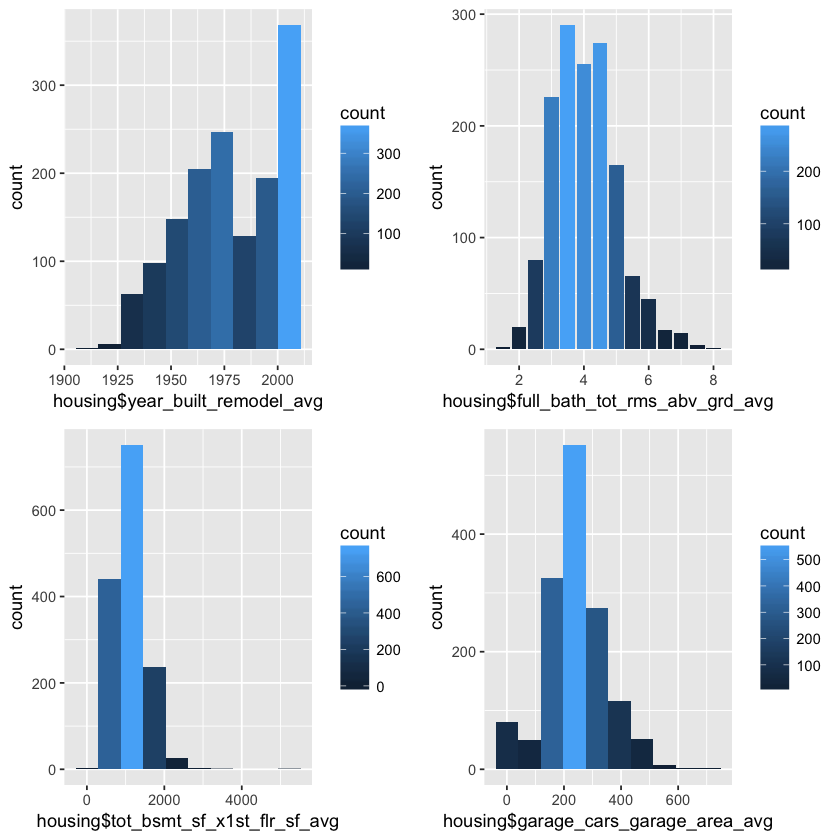

In [23]:
p1 <- ggplot(data= housing, aes(housing$year_built_remodel_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
p2 <- ggplot(data= housing, aes(housing$tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
p3 <- ggplot(data= housing, aes(housing$full_bath_tot_rms_abv_grd_avg)) + geom_bar(aes(fill= ..count..))
p4 <- ggplot(data= housing, aes(housing$garage_cars_garage_area_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
multiplot(p1, p2, p3, p4, cols=2)

In [24]:
#log, square root, inverse
housing$log_year_built_remodel_avg <- log(housing$year_built_remodel_avg)
housing$log10_year_built_remodel_avg <- log10(housing$year_built_remodel_avg)
housing$exp_year_built_remodel_avg <- exp(housing$year_built_remodel_avg)
housing$abs_year_built_remodel_avg <- abs(housing$year_built_remodel_avg)
housing$sqrt_year_built_remodel_avg <- sqrt(housing$year_built_remodel_avg)
housing$inverse_year_built_remodel_avg <- 1/(housing$year_built_remodel_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

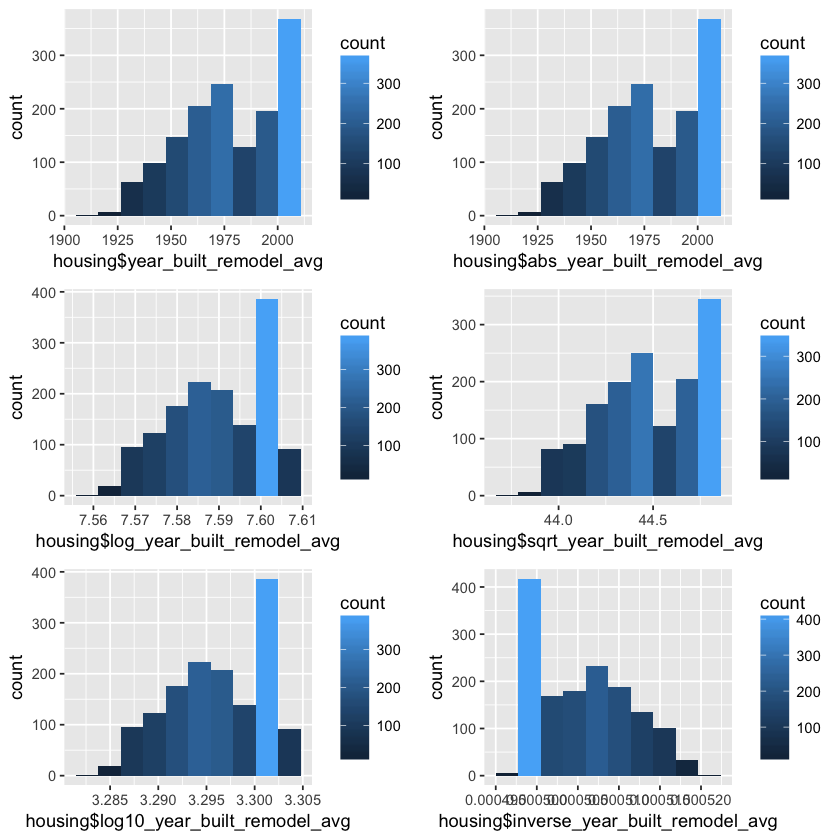

In [25]:
p5 <- ggplot(data= housing, aes(housing$log_year_built_remodel_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
p6 <- ggplot(data= housing, aes(housing$log10_year_built_remodel_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
p7 <- ggplot(data= housing, aes(housing$abs_year_built_remodel_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
p8 <- ggplot(data= housing, aes(housing$sqrt_year_built_remodel_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
p9 <- ggplot(data= housing, aes(housing$inverse_year_built_remodel_avg)) + geom_histogram(bins = 10, aes(fill = ..count..))
multiplot(p1, p5, p6, p7,p8, p9, cols = 2)

In [26]:
#Perform a Shapiro-Wilk test for normality of residuals
#null hypothesis states data is normally distributed. if p-value is significant should reject null hypothesis.
#p-value is significant so we can reject the null hypothesis of normality and assume the data is non- normal 
#can choose not to use the transformation or use abs_year_built_remodel_avg 
#for the most approximately normal dist
print(shapiro.test(housing$year_built_remodel_avg))
print(shapiro.test(housing$log_year_built_remodel_avg))
print(shapiro.test(housing$inverse_year_built_remodel_avg))
print(shapiro.test(housing$log10_year_built_remodel_avg))
print(shapiro.test(housing$abs_year_built_remodel_avg))
print(shapiro.test(housing$sqrt_year_built_remodel_avg))


	Shapiro-Wilk normality test

data:  housing$year_built_remodel_avg
W = 0.93696, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$log_year_built_remodel_avg
W = 0.93658, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$inverse_year_built_remodel_avg
W = 0.93617, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$log10_year_built_remodel_avg
W = 0.93658, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$abs_year_built_remodel_avg
W = 0.93696, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$sqrt_year_built_remodel_avg
W = 0.93678, p-value < 2.2e-16



In [27]:
#log, square root, inverse
housing$log_tot_bsmt_sf_x1st_flr_sf_avg <- log(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$log10_tot_bsmt_sf_x1st_flr_sf_avg <- log10(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$abs_tot_bsmt_sf_x1st_flr_sf_avg <- abs(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$sqrt_tot_bsmt_sf_x1st_flr_sf_avg <- sqrt(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$inverse_tot_bsmt_sf_x1st_flr_sf_avg <- 1/(housing$tot_bsmt_sf_x1st_flr_sf_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

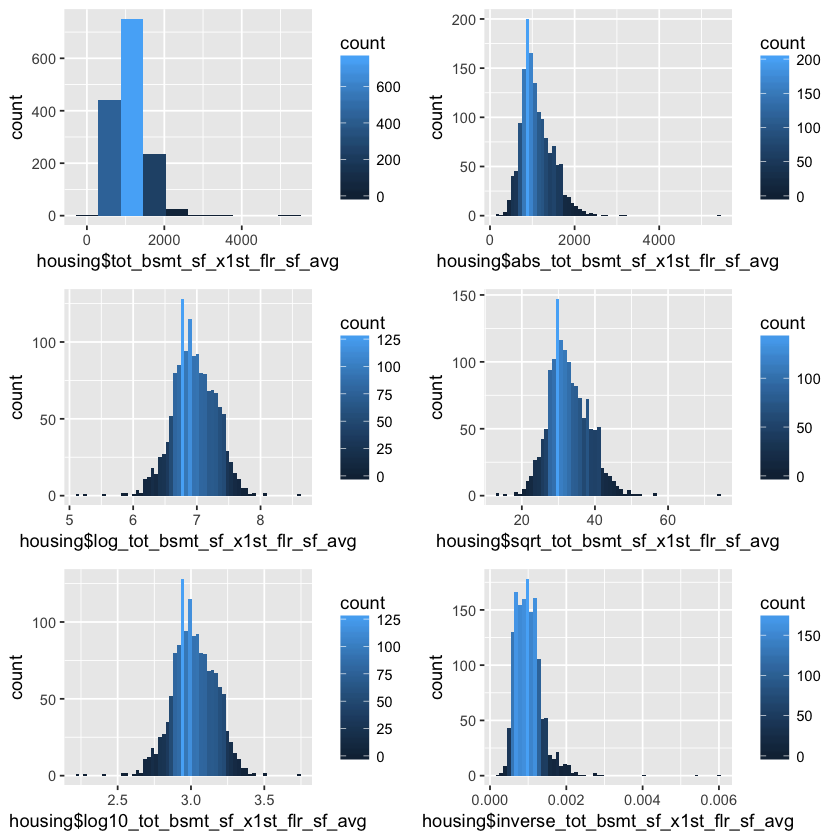

In [28]:
p10 <- ggplot(data= housing, aes(housing$log_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60, aes(fill = ..count..))
p11 <- ggplot(data= housing, aes(housing$log10_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60, aes(fill = ..count..))
p12 <- ggplot(data= housing, aes(housing$abs_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60, aes(fill = ..count..))
p13 <- ggplot(data= housing, aes(housing$sqrt_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60, aes(fill = ..count..))
p14 <- ggplot(data= housing, aes(housing$inverse_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60, aes(fill = ..count..))
multiplot(p2, p10, p11, p12,p13, p14, cols = 2)

In [29]:
#the data is non- normal 
#we can go with the log or log10 transformation
print(shapiro.test(housing$tot_bsmt_sf_x1st_flr_sf_avg))
print(shapiro.test(housing$log_tot_bsmt_sf_x1st_flr_sf_avg))
print(shapiro.test(housing$log10_tot_bsmt_sf_x1st_flr_sf_avg))
print(shapiro.test(housing$abs_tot_bsmt_sf_x1st_flr_sf_avg))
print(shapiro.test(housing$sqrt_tot_bsmt_sf_x1st_flr_sf_avg))


	Shapiro-Wilk normality test

data:  housing$tot_bsmt_sf_x1st_flr_sf_avg
W = 0.91326, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$log_tot_bsmt_sf_x1st_flr_sf_avg
W = 0.98875, p-value = 3.479e-09


	Shapiro-Wilk normality test

data:  housing$log10_tot_bsmt_sf_x1st_flr_sf_avg
W = 0.98875, p-value = 3.479e-09


	Shapiro-Wilk normality test

data:  housing$abs_tot_bsmt_sf_x1st_flr_sf_avg
W = 0.91326, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$sqrt_tot_bsmt_sf_x1st_flr_sf_avg
W = 0.97635, p-value = 9.282e-15



In [30]:
#log, square root, inverse
housing$log_garage_cars_garage_area_avg <- log(housing$garage_cars_garage_area_avg)
housing$log10_garage_cars_garage_area_avg <- log10(housing$garage_cars_garage_area_avg)
housing$abs_garage_cars_garage_area_avg <- abs(housing$garage_cars_garage_area_avg)
housing$sqrt_garage_cars_garage_area_avg <- sqrt(housing$garage_cars_garage_area_avg)
housing$inverse_garage_cars_garage_area_avg <- 1/(housing$garage_cars_garage_area_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

Warning message:
“Removed 81 rows containing non-finite values (stat_bin).”Warning message:
“Removed 81 rows containing non-finite values (stat_bin).”Warning message:
“Removed 81 rows containing non-finite values (stat_bin).”

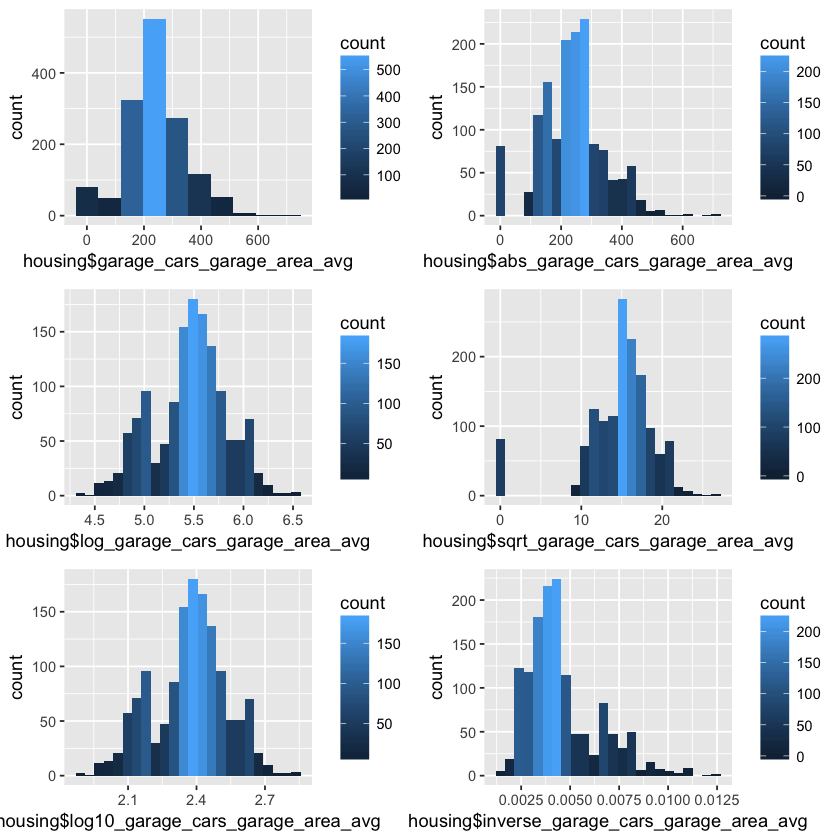

In [31]:
p11 <- ggplot(data= housing, aes(housing$log_garage_cars_garage_area_avg)) + geom_histogram(bins = 24, aes(fill = ..count..))
p12 <- ggplot(data= housing, aes(housing$log10_garage_cars_garage_area_avg)) + geom_histogram(bins = 24, aes(fill = ..count..))
p13 <- ggplot(data= housing, aes(housing$abs_garage_cars_garage_area_avg)) + geom_histogram(bins = 24, aes(fill = ..count..))
p14 <- ggplot(data= housing, aes(housing$sqrt_garage_cars_garage_area_avg)) + geom_histogram(bins = 24, aes(fill = ..count..))
p15 <- ggplot(data= housing, aes(housing$inverse_garage_cars_garage_area_avg)) + geom_histogram(bins = 24, aes(fill = ..count..))

multiplot(p4, p11, p12, p13,p14, p15, cols = 2)

In [32]:
#the data is non- normal 
#keep untransformed data or abs 
print(shapiro.test(housing$garage_cars_garage_area_avg))
print(shapiro.test(housing$log_garage_cars_garage_area_avg))
print(shapiro.test(housing$log10_garage_cars_garage_area_avg))
print(shapiro.test(housing$abs_garage_cars_garage_area_avg))
print(shapiro.test(housing$sqrt_garage_cars_garage_area_avg))
print(shapiro.test(housing$inverse_garage_cars_garage_area_avg))


	Shapiro-Wilk normality test

data:  housing$garage_cars_garage_area_avg
W = 0.9753, p-value = 3.922e-15


	Shapiro-Wilk normality test

data:  housing$log_garage_cars_garage_area_avg
W = NaN, p-value = NA


	Shapiro-Wilk normality test

data:  housing$log10_garage_cars_garage_area_avg
W = NaN, p-value = NA


	Shapiro-Wilk normality test

data:  housing$abs_garage_cars_garage_area_avg
W = 0.9753, p-value = 3.922e-15


	Shapiro-Wilk normality test

data:  housing$sqrt_garage_cars_garage_area_avg
W = 0.84386, p-value < 2.2e-16


	Shapiro-Wilk normality test

data:  housing$inverse_garage_cars_garage_area_avg
W = NaN, p-value = NA



## Non - Linear Data

Use quadratic transformations to change non-linear data into linear if the model assumes a linear relationship between the outcome and feature variable. Linear transformations can be achieved by squaring, cubing, etc. 

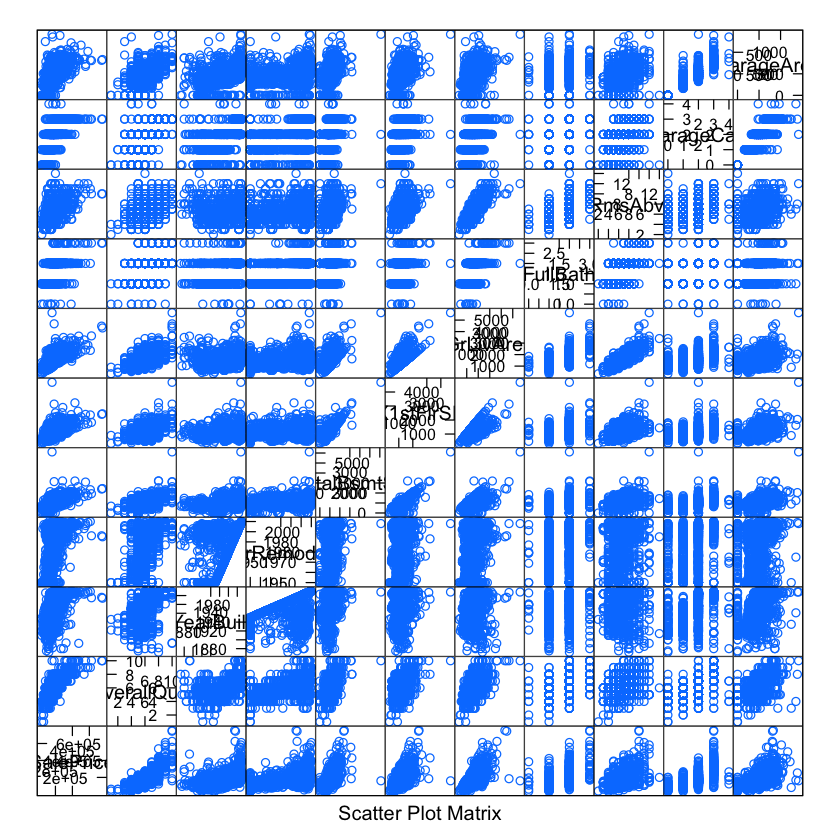

In [49]:
#REMEMBER pick new relationship that's non-linear for example below
names = c("SalePrice", "OverallQual" , "YearBuilt" , "YearRemodAdd" , "TotalBsmtSF" , "X1stFlrSF" , "GrLivArea" 
, "FullBath" , "TotRmsAbvGrd" , "GarageCars" , "GarageArea")
splom_df <- numeric_df[names]
splom(splom_df)

In [47]:
linear_trans_year_remod <- splom_df$TotRmsAbvGrd * splom_df$TotRmsAbvGrd

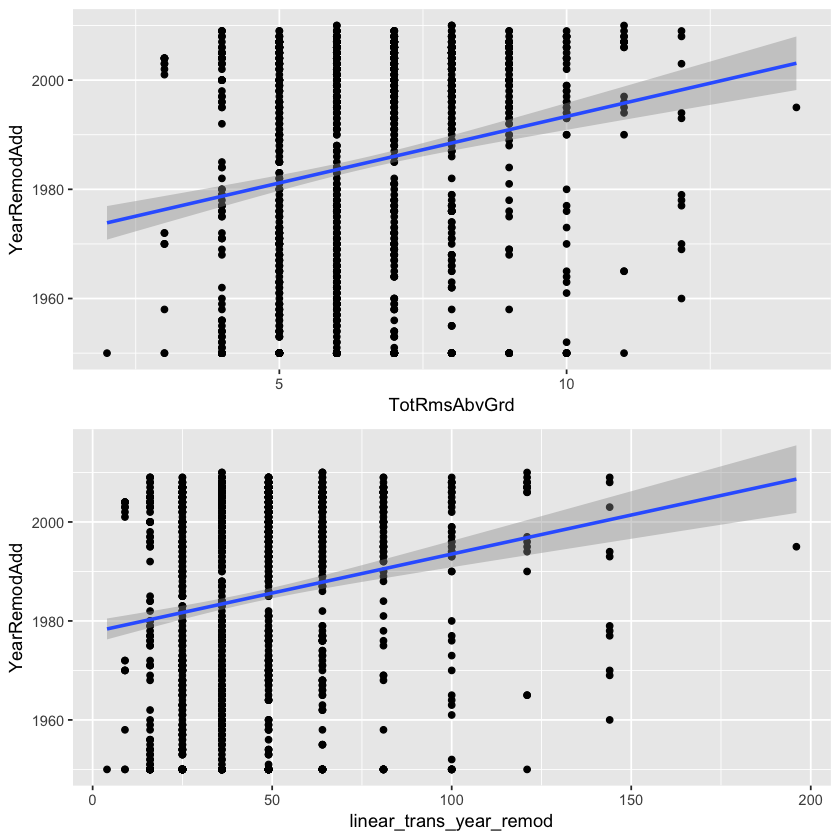

In [48]:
comp_1 <- ggplot(splom_df, aes(x=TotRmsAbvGrd, y=YearRemodAdd)) +
      geom_point() + 
  geom_smooth(method='lm',formula=y~x) +
      theme(legend.position="none")
comp_2 <- ggplot(splom_df, aes(x=linear_trans_year_remod, y=YearRemodAdd)) +
      geom_point() +
  geom_smooth(method='lm',formula=y~x) +
      theme(legend.position="none")
multiplot(comp_1, comp_2, cols = 1)

## Normalizing Variables

If you have data in different ranges, it may be useful to normalize your data. When you normalize your data, you transform your data into data points between a range (where the mean is normally 0, and the standard deviation is equal to 1). 

In [36]:
normalized_data <- scale(numeric_df)
head(normalized_data)

Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
-1.730272,0.07334983,-0.2079477,-0.20707076,0.65125610,-0.5170227,1.0506338,0.8783671,0.5098397,0.57522774,⋯,-0.7519182,0.21642900,-0.3592018,-0.1162994,-0.2701158,-0.06866822,-0.08765778,-1.5985634,0.1387300,0.347154270
-1.727900,-0.87226388,0.4097238,-0.09185490,-0.07181151,2.1788812,0.1566800,-0.4294298,-0.5726373,1.17159068,⋯,1.6256378,-0.70424195,-0.3592018,-0.1162994,-0.2701158,-0.06866822,-0.08765778,-0.4889425,-0.6142282,0.007285824
-1.725528,0.07334983,-0.0844134,0.07345481,0.65125610,-0.5170227,0.9844150,0.8299302,0.3220631,0.09287536,⋯,-0.7519182,-0.07033736,-0.3592018,-0.1162994,-0.2701158,-0.06866822,-0.08765778,0.9905519,0.1387300,0.535970074
-1.723156,0.30975326,-0.4138382,-0.09686428,0.65125610,-0.5170227,-1.8629933,-0.7200514,-0.5726373,-0.49910256,⋯,-0.7519182,-0.17598812,4.0911220,-0.1162994,-0.2701158,-0.06866822,-0.08765778,-1.5985634,-1.3671863,-0.515104565
-1.720785,0.07334983,0.5744362,0.37501979,1.37432370,-0.5170227,0.9513056,0.7330564,1.3603573,0.46340969,⋯,0.7799299,0.56356723,-0.3592018,-0.1162994,-0.2701158,-0.06866822,-0.08765778,2.1001728,0.1387300,0.869544659
-1.718413,-0.16305360,0.6156143,0.36049258,-0.79487911,-0.5170227,0.7195398,0.4908717,-0.5726373,0.63223302,⋯,-0.4327832,-0.25145296,-0.3592018,10.7987462,-0.2701158,-0.06866822,1.32328259,1.3604256,0.8916881,-0.477341404


In [37]:
colMeans(normalized_data)

Id    MSSubClass   LotFrontage       LotArea   OverallQual 
-8.364694e-19 -9.297167e-17            NA -6.790967e-17  1.112314e-16 
  OverallCond     YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1 
 3.288085e-16  1.053719e-15  4.488315e-15            NA -2.315262e-17 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF 
 7.171775e-18 -7.250075e-17  2.515212e-16  6.568067e-17  3.307678e-17 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
 1.387779e-18 -1.389906e-16  7.878021e-17 -7.984481e-18  1.891942e-16 
     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces 
 2.653889e-17  2.805214e-16  3.580089e-16 -1.041785e-16 -6.083414e-18 
  GarageYrBlt    GarageCars    GarageArea    WoodDeckSF   OpenPorchSF 
           NA  7.436973e-17 -1.657077e-17  4.867682e-17  1.920315e-17 
EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea       MiscVal 
 3.703753e-17 -1.140640e-19  3.779321e-17 -1.235693e-19 -7.832395e-18 
       MoSold        YrSold     SalePrice 
 1.080091e-16  3.560288e-14  1.340721e-16

## Interaction Terms

Sometimes there are features related to outcomes with dependencies on another feature. For example, let's say you think the properties with vaster square footage have higher sale prices if they have additional bathrooms. The interaction is represented by multiplying the X1stFlrSF feature by FullBath.

In [38]:
housing$int_1stflrsf_fullbath <- housing$X1stFlrSF * housing$FullBath
print(head(housing$X1stFlrSF))
print(head(housing$FullBath))
print(head(housing$int_1stflrsf_fullbath))

[1]  856 1262  920  961 1145  796
[1] 2 2 2 1 2 1
[1] 1712 2524 1840  961 2290  796


## Singular Value Decomposition

In [41]:
(s <- svd(X))
D <- diag(s$d)

ERROR: Error in as.matrix(x): object 'X' not found


In [40]:
s$u %*% D %*% t(s$v) #  X = U D V'

ERROR: Error in eval(expr, envir, enclos): object 's' not found


In [ ]:
#same as above
A = s$u %*% diag(s$d)  %*% t(s$v)
A

## Principal Components Analysis

PCA is a form of dimensionality reduction where we aim to reduce our dataset from n features to k features while still maintaining the maximum variance explained desired for our model. PCA works best on data weakly to moderately correlated data meeting the assumptions for normality and linearity.

Eigenvector

Eigenvalue
when linear transformation occurs the direction of the eigenvalue vector changes



In [ ]:
#principal component analysis
prin_comp <- prcomp(na.omit(numeric_df), scale. = T)
names(prin_comp)

In [ ]:
#outputs the mean of variables
prin_comp$center

In [ ]:
#outputs the standard deviation of variables
prin_comp$scale

In [ ]:
prin_comp$rotation

In [ ]:
 prin_comp$rotation[1:5,1:4]

In [ ]:
dim(prin_comp$x)

In [ ]:
biplot(prin_comp, scale = 1)

In [ ]:
#compute standard deviation of each principal component
std_dev <- prin_comp$sdev
#compute variance
pr_var <- std_dev^2
#check variance of first 10 components
pr_var[1:10]

In [ ]:
#proportion of variance explained
prop_varex <- pr_var/sum(pr_var)
prop_varex[1:20]


In [ ]:
#scree plot
plot(prop_varex, xlab = "Principal Component",
        ylab = "Proportion of Variance Explained",
        type = "b")

In [ ]:
#cumulative scree plot
plot(cumsum(prop_varex), xlab = "Principal Component",
        ylab = "Cumulative Proportion of Variance Explained",
        type = "b")

In [ ]:
sum(prop_varex[1:27])

In [ ]:
pca_cor_matrix <- cor(na.omit(numeric_df), prin_comp$x )

In [ ]:
#st the lower diagonal of the correlation matrix to NA
pca_cor_matrix[lower.tri(pca_cor_matrix, diag = TRUE)] <- NA  
#melt and subset correlation matrix
PCACM <- subset(melt(pca_cor_matrix, na.rm = TRUE), value > .00)   
#look at the features highly correlated with the dependent feature
PCACM

In [ ]:
cor_pca <- subset(PCACM, PCACM[2] == 'PC38')
cor_pca

In [ ]:
summary(PCACM)